In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import random
import gym
from gym import spaces

from sklearn.preprocessing import LabelEncoder

In [2]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [3]:
import csv

menu_dict = {}
first = True
with open("./menu.csv", 'r', encoding='EUC-KR') as file:
    reader = csv.reader(file)
    for row in reader:
        if first:
          first=False
          continue
        idx, menu = row
        menu_dict[int(idx)] = menu
menu_dict

{0: '1명 닭꼬치',
 1: '간장치킨',
 2: '갈비탕',
 3: '강된장보리밥',
 4: '고구마치즈돈가스',
 5: '고구마피자',
 6: '고기',
 7: '고등어회',
 8: '곱창',
 9: '국밥',
 10: '김치볶음밥',
 11: '김치전',
 12: '김치찌개',
 13: '낙곱새',
 14: '냉면',
 15: '냉소바',
 16: '닭갈비',
 17: '닭강정',
 18: '닭꼬치',
 19: '닭똥집튀김',
 20: '닭발',
 21: '닭볶음탕',
 22: '닭우동',
 23: '대창',
 24: '덮밥',
 25: '돈가스',
 26: '돼지갈비',
 27: '돼지고기김치찜',
 28: '돼지국밥',
 29: '된장찌개',
 30: '두부김치',
 31: '떡볶이',
 32: '라면',
 33: '로제떡볶이',
 34: '로제마라샹궈',
 35: '마라떡볶이',
 36: '마라탕',
 37: '마제소바',
 38: '막국수',
 39: '멘보샤',
 40: '무뼈닭발',
 41: '바게트',
 42: '바나나 한개',
 43: '밥버거',
 44: '백반',
 45: '봉구스밥버거',
 46: '부대찌개',
 47: '분짜',
 48: '불고기백반',
 49: '불고기피자',
 50: '불닭게티',
 51: '비빔국수',
 52: '사케동',
 53: '삼각김밥',
 54: '삼겹살',
 55: '새우초밥',
 56: '샌드위치',
 57: '선지해장국',
 58: '설렁탕',
 59: '소고기덮밥',
 60: '소고기무국',
 61: '소곱창',
 62: '소바',
 63: '솥밥',
 64: '순대국',
 65: '순대국밥',
 66: '순두부찌개',
 67: '스테이크',
 68: '스파게티',
 69: '쌀국수',
 70: '씨리얼',
 71: '야끼소바',
 72: '양꼬치',
 73: '양념치킨',
 74: '양송이수프',
 75: '연어덮밥',
 76: '연어초밥',
 77: '연어회',
 78: '열무국수',
 7

In [4]:
# DQN 모델 정의 (이전에 정의한 것과 동일해야 함)
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# 에이전트 정의 (이전에 정의한 것과 동일해야 함)
class DQNAgent:
    def __init__(self, state_dim, action_dim, replay_buffer):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.replay_buffer = replay_buffer
        self.model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0005)
        self.epsilon = 0.1  # 사용자 입력에서는 낮은 탐색 확률 사용
        self.epsilon_min = 0.01

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
        # action = q_values.max(1)[1].item()
        top_k = 3
        _, top_k_indices = q_values.topk(top_k, dim=1, largest=True, sorted=True)

        # top_k_indices는 (1, 3) 형태의 텐서이므로, 이를 리스트로 변환
        top_k_actions = top_k_indices.squeeze().tolist()
        return top_k_actions, q_values

    def update_model(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return
        batch = self.replay_buffer.sample(batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        current_q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        max_next_q_values = self.model(next_states).max(1)[0]
        expected_q_values = rewards + (1 - dones) * 0.99 * max_next_q_values

        loss = nn.MSELoss()(current_q_values, expected_q_values.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# 모델 및 에이전트 초기화
state_dim = 6  # 상태 차원 (예시)
action_dim = len(menu_dict)  # 행동 차원 (예시, 메뉴 수)
replay_buffer = ReplayBuffer(10000)
agent = DQNAgent(state_dim, action_dim, replay_buffer)

In [6]:
# 체크포인트에서 모델 불러오기
checkpoint_path = './top_k_model/top_k_final_model_state_dict.pth'  # 예시 체크포인트 경로
checkpoint = torch.load(checkpoint_path)
agent.model.load_state_dict(checkpoint)
agent.model.eval()

DQN(
  (fc1): Linear(in_features=6, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=116, bias=True)
)

In [7]:
def get_user_input():
    # 상태 정보 입력 받기
    feeling = input_with_validation("기분을 숫자로 입력하세요 (예: 1~10, 1: 최악, 10: 최고): ", 1, 10)
    weather = input_with_validation("날씨를 숫자로 입력하세요 (예: 0: 맑음, 1: 구름, 2: 흐림, 3: 비, 4: 눈): ", 0, 4)
    temp = input_with_validation("체감 온도를 숫자로 입력하세요 (예: 1~10, 1: 추움, 10: 더움): ", 1, 10)
    time = input_with_validation("체감 식사 시간대를 입력하세요 (0: 아침, 1: 점심, 2: 저녁, 3: 야식): ", 0, 3)
    num_people = input_with_validation("인원수를 숫자로 입력하세요 (예: 1, 2, 3, 4 or 5명 이상: 5): ", 1, 5)
    gender = input_with_validation("성별을 입력하세요 (0: 남성, 1: 여성): ", 0, 1)

    # 모든 입력값을 실수형 리스트로 변환하여 반환
    return [feeling, weather, temp, time, num_people, gender]

def input_with_validation(prompt, min_val, max_val):
    while True:
        try:
            value = float(input(prompt))
            if min_val <= value <= max_val:
                return value
            else:
                print(f"입력값은 {min_val}에서 {max_val} 사이여야 합니다. 다시 입력해주세요.")
        except ValueError:
            print("유효한 숫자를 입력해주세요.")

In [8]:
def get_user_feedback2(actions):
    print("추천된 메뉴:")
    for action in actions:
        menu = menu_dict[action]
        print(f"- 메뉴: {menu}")

    feedbacks = []
    for action in actions:
        menu = menu_dict[action]
        while True:
            try:
                star_rating = int(input(f"{menu}에 대한 별점을 1~5 사이로 평가해 주세요: "))
                if 1 <= star_rating <= 5:
                    break
                else:
                    print("별점은 1에서 5 사이의 값이어야 합니다.")
            except ValueError:
                print("유효한 숫자를 입력해주세요.")
        reward = star_rating  # 직접적으로 별점을 보상으로 사용
        feedbacks.append((action, reward))
    return feedbacks

In [28]:
import matplotlib.pyplot as plt

# 전역 변수로 보상 리스트를 관리합니다.
rewards = []

def run_interaction_and_update_model2():
    global rewards
    try:
        # 사용자 입력 받기
        state = get_user_input()  # 상태 입력 받기
        actions, q_value = agent.select_action(state)  # 모델을 통해 액션(메뉴) 추천 받기

        # 별점 기반 피드백 수집
        feedbacks = get_user_feedback2(actions)

        current_episode_reward = 0  # 현재 에피소드의 총 보상 초기화

        # 각 메뉴에 대한 별점을 리플레이 버퍼에 저장
        for action, star_rating in feedbacks:
            next_state = state  # 다음 상태 (상태 변화 없음)
            done = True  # 단일 스텝이므로 에피소드 종료
            reward = star_rating-2  # 별점을 보상으로 사용
            current_episode_reward += reward  # 총 보상 갱신
            agent.replay_buffer.push(state, action, reward, next_state, done)

        # 모델 업데이트
        if len(agent.replay_buffer) > 0:
            agent.update_model(batch_size=1)  # 단일 사용자 피드백을 반영
            print("Model updated successfully based on the latest interaction.")
            rewards.append(current_episode_reward)  # 에피소드 보상을 리스트에 추가
            print(actions)
        else:
            print("Not enough data in buffer to update model.")
        return q_value
    except Exception as e:
        print(f"An error occurred: {e}")

In [29]:
# 모델 및 에이전트 초기화 및 실행
agent = DQNAgent(state_dim, action_dim, ReplayBuffer(10000))

In [36]:
q_value = run_interaction_and_update_model2()
q_value

추천된 메뉴:
- 메뉴: 짜파게티
- 메뉴: 크림파스타
- 메뉴: 양꼬치
Model updated successfully based on the latest interaction.
[89, 100, 72]


tensor([[ 0.0245,  0.0434,  0.0519,  0.0979, -0.0672, -0.1296, -0.0637, -0.1870,
         -0.2080, -0.0489,  0.1967, -0.0688, -0.0598, -0.0243, -0.0218, -0.2978,
         -0.0439, -0.0124, -0.2386,  0.0543, -0.2050, -0.0450, -0.0397, -0.2085,
         -0.0140, -0.0944, -0.0212,  0.1304, -0.2198,  0.0313,  0.1309, -0.1062,
          0.1091,  0.0008, -0.1076, -0.0423, -0.0770,  0.1367, -0.0388, -0.2258,
         -0.1305, -0.0397,  0.0366,  0.0467, -0.1535, -0.0115, -0.0218,  0.1606,
          0.0068,  0.0172, -0.1234, -0.1119,  0.0551, -0.0248,  0.0295,  0.1385,
         -0.0562, -0.0505,  0.0817, -0.2480,  0.1059, -0.0226,  0.1450, -0.0508,
         -0.0596, -0.1298,  0.0971, -0.0095, -0.1165,  0.0463, -0.0879,  0.0970,
          0.2100,  0.0550,  0.0104, -0.0228,  0.0205, -0.1428, -0.0405, -0.1744,
         -0.1206, -0.0143, -0.0457, -0.1563,  0.1643, -0.0027, -0.0910,  0.1150,
          0.1589,  0.2417,  0.0868,  0.1025, -0.1001,  0.1904, -0.2226,  0.0877,
          0.0147, -0.0595, -

In [12]:
torch.save(agent.model.state_dict(), './top_k_model/top_k_final_model_state_dict.pth')
torch.save(agent.model, './top_k_model/top_k_final_model.pth')

In [13]:
menu_dict.values()

dict_values(['1명 닭꼬치', '간장치킨', '갈비탕', '강된장보리밥', '고구마치즈돈가스', '고구마피자', '고기', '고등어회', '곱창', '국밥', '김치볶음밥', '김치전', '김치찌개', '낙곱새', '냉면', '냉소바', '닭갈비', '닭강정', '닭꼬치', '닭똥집튀김', '닭발', '닭볶음탕', '닭우동', '대창', '덮밥', '돈가스', '돼지갈비', '돼지고기김치찜', '돼지국밥', '된장찌개', '두부김치', '떡볶이', '라면', '로제떡볶이', '로제마라샹궈', '마라떡볶이', '마라탕', '마제소바', '막국수', '멘보샤', '무뼈닭발', '바게트', '바나나 한개', '밥버거', '백반', '봉구스밥버거', '부대찌개', '분짜', '불고기백반', '불고기피자', '불닭게티', '비빔국수', '사케동', '삼각김밥', '삼겹살', '새우초밥', '샌드위치', '선지해장국', '설렁탕', '소고기덮밥', '소고기무국', '소곱창', '소바', '솥밥', '순대국', '순대국밥', '순두부찌개', '스테이크', '스파게티', '쌀국수', '씨리얼', '야끼소바', '양꼬치', '양념치킨', '양송이수프', '연어덮밥', '연어초밥', '연어회', '열무국수', '요거트아이스크림', '유부초밥', '육회', '자장면', '전', '제육덮밥', '제육볶음', '족발', '직화고기', '짜장면', '짜파게티', '쫄면', '쭈꾸미볶음', '청국장', '초밥', '추어탕', '치즈돈까스', '치킨', '치킨, 고기, 막걸리, 파전, 샐러드', '칼국수', '콩나물국밥육개장', '크림파스타', '타코야끼', '투움바파스타', '파스타', '파전', '페퍼로니피자', '포케', '피자', '하와이안피자', '항정살덮밥', '해장국', '햄버거', '허니콤보', '화채', '회', '회덮밥'])

In [37]:
def softmax(x):
    # 입력 배열 x에 대해 softmax 연산 수행
    exp_x = np.exp(x - np.max(x))  # 입력 배열에서 최대값을 빼준 후 softmax 계산
    softmax_x = exp_x / np.sum(exp_x)  # softmax 계산
    return softmax_x

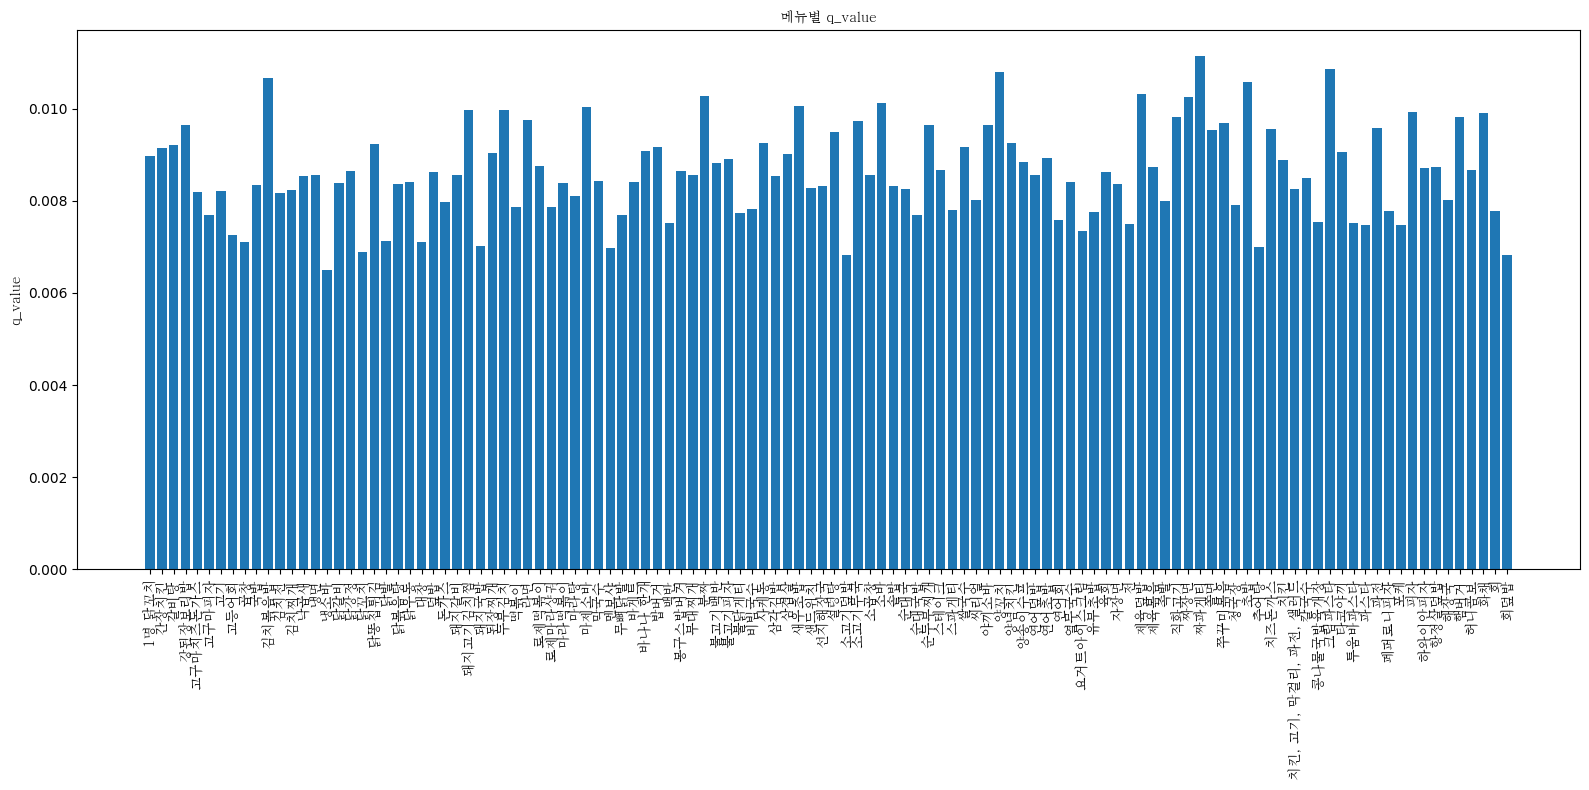

In [38]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

# 한글 폰트 설정
path = 'C:/Windows/Fonts/batang.ttc'  # 사용할 한글 폰트 파일 경로
fontprop = fm.FontProperties(fname=path)

# 그래프 그리기
plt.figure(figsize=(16, 8))
plt.bar(menu_dict.values(), softmax(q_value.numpy().flatten()))

# x축 레이블 폰트 설정
plt.xticks(rotation=90, ha='center', fontsize=10, fontproperties=fontprop)
plt.ylabel('q_value', fontproperties=fontprop)  # y축 레이블
plt.title('메뉴별 q_value', fontproperties=fontprop)  # 그래프 제목

plt.tight_layout()  # 그래프 레이아웃 조정
plt.show()